In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("WeatherDataAnalysis") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/16 23:21:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [35]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import requests
import pandas as pd

API_KEY = "5fee2ce62aa847d6bea52d442e42814a"
base_url = "http://api.openweathermap.org/data/2.5/weather"

# Define schema
schema = StructType([
    StructField("City", StringType(), True),
    StructField("Temperature", DoubleType(), True),
    StructField("Humidity", DoubleType(), True),
    StructField("WindSpeed", DoubleType(), True),
    StructField("Weather", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True)
])

# Function to fetch weather data
def fetch_weather_data(city):
    params = {"q": city, "appid": API_KEY, "units": "metric"}
    response = requests.get(base_url, params=params)
    data = response.json()
    if data.get("main"):
        return Row(
            City=data["name"],
            Temperature=float(data["main"]["temp"]),
            Humidity=float(data["main"]["humidity"]),
            WindSpeed=float(data["wind"]["speed"]),
            Weather=data["weather"][0]["description"],
            Latitude=float(data["coord"]["lat"]),
            Longitude=float(data["coord"]["lon"])
        )

# Cities list
cities = [
    "Srinagar", "Leh", "Shimla", "Chandigarh", "Dehradun", "New Delhi", "Jaipur", "Amritsar",
    "Ahmedabad", "Mumbai", "Jaisalmer", "Panaji",
    "Bhopal", "Raipur", "Nagpur",
    "Kolkata", "Patna", "Darjeeling",
    "Bengaluru", "Chennai", "Hyderabad", "Thiruvananthapuram",
    "Guwahati", "Shillong", "Aizawl"
]

# Fetch data
weather_rows = [fetch_weather_data(city) for city in cities if fetch_weather_data(city) is not None]

# Create DataFrame with defined schema
weather_df = spark.createDataFrame(weather_rows, schema=schema)

# Show the DataFrame
weather_df.show()
pandas_df = weather_df.toPandas()

+----------+-----------+--------+---------+----------------+--------+---------+
|      City|Temperature|Humidity|WindSpeed|         Weather|Latitude|Longitude|
+----------+-----------+--------+---------+----------------+--------+---------+
|  Srinagar|      -0.05|    65.0|     0.76|scattered clouds| 34.0833|  74.8167|
|       Leh|     -19.08|   100.0|     0.91| overcast clouds| 34.1667|  77.5833|
|    Shimla|      -0.31|    82.0|     2.76|       clear sky|    31.1|  77.1667|
|Chandigarh|      10.91|    66.0|     2.15|       clear sky| 30.7343|  76.7933|
|  Dehradun|      10.15|    74.0|     2.67|       clear sky| 30.3256|  78.0437|
| New Delhi|      12.09|    94.0|     1.03|            mist| 28.6128|  77.2311|
|    Jaipur|      10.62|    93.0|      0.0|             fog| 26.9167|  75.8167|
|  Amritsar|       8.97|   100.0|     2.57|             fog| 31.6331|  74.8656|
| Ahmedabad|      18.02|    45.0|     6.17|           smoke| 23.0333|  72.6167|
|    Mumbai|      24.99|    65.0|      0

In [36]:
# Add a severity column based on temperature
from pyspark.sql.functions import when

weather_df = weather_df.withColumn(
    "Severity",
    when(weather_df.Temperature > 35, "High")
    .when(weather_df.Temperature > 20, "Moderate")
    .otherwise("Low")
)

# Group by Severity
severity_count = weather_df.groupBy("Severity").count()
severity_count.show()

+--------+-----+
|Severity|count|
+--------+-----+
|     Low|   18|
|Moderate|    7|
+--------+-----+



In [37]:
# Calculate the average temperature, humidity, and wind speed
average_temp = pandas_df["Temperature"].mean()
average_humidity = pandas_df["Humidity"].mean()
average_wind_speed = pandas_df["WindSpeed"].mean()


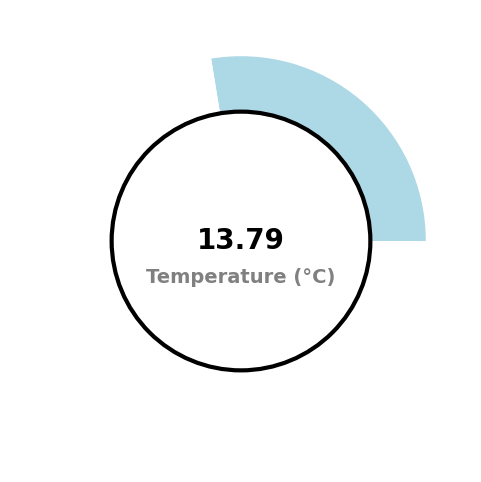

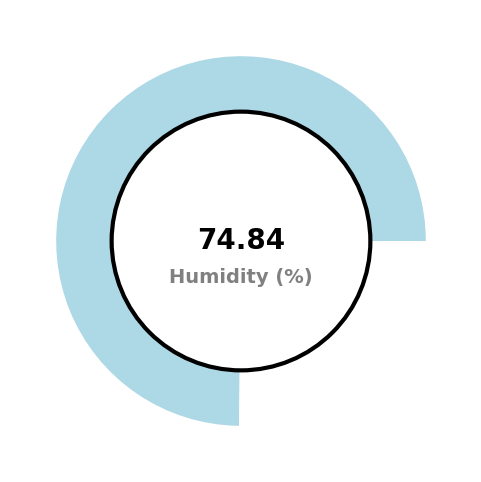

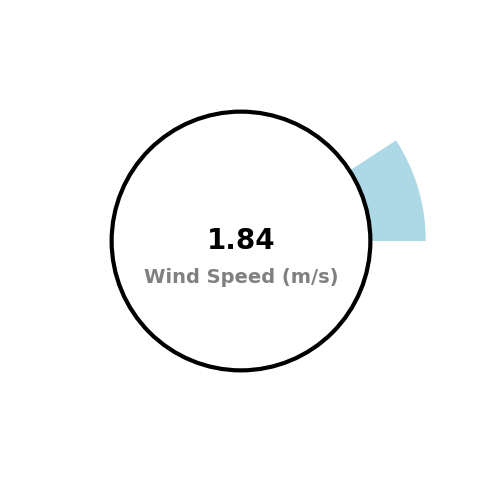

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def create_gauge_chart(value, title, min_val, max_val):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a circular gauge
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Define the color palette with a gradient-like effect
    colors = ["lightblue", "white"]
    
    # Compute the angle based on the value
    angle = (value - min_val) / (max_val - min_val) * 180

    # Create the gauge segments
    ax.pie([angle, 180 - angle], startangle=0, colors=colors, wedgeprops={'width': 0.3})
    
    # Add a border circle to give it a more polished look
    circle = plt.Circle((0, 0), 0.7, color='black', fill=False, linewidth=3)
    ax.add_artist(circle)

    # Add title and value text
    ax.text(0, 0, f"{value:.2f}", ha='center', va='center', fontweight="bold", fontsize=20, color="black")
    ax.text(0, -0.2, title, ha='center', va='center', fontweight="bold", fontsize=14, color='gray')
    
    # Remove axes
    ax.axis('off')
    
    # Show the plot
    plt.show()

# Example usage
create_gauge_chart(average_temp, "Temperature (°C)", min_val=0, max_val=50)
create_gauge_chart(average_humidity, "Humidity (%)", min_val=0, max_val=100)
create_gauge_chart(average_wind_speed, "Wind Speed (m/s)", min_val=0, max_val=20)


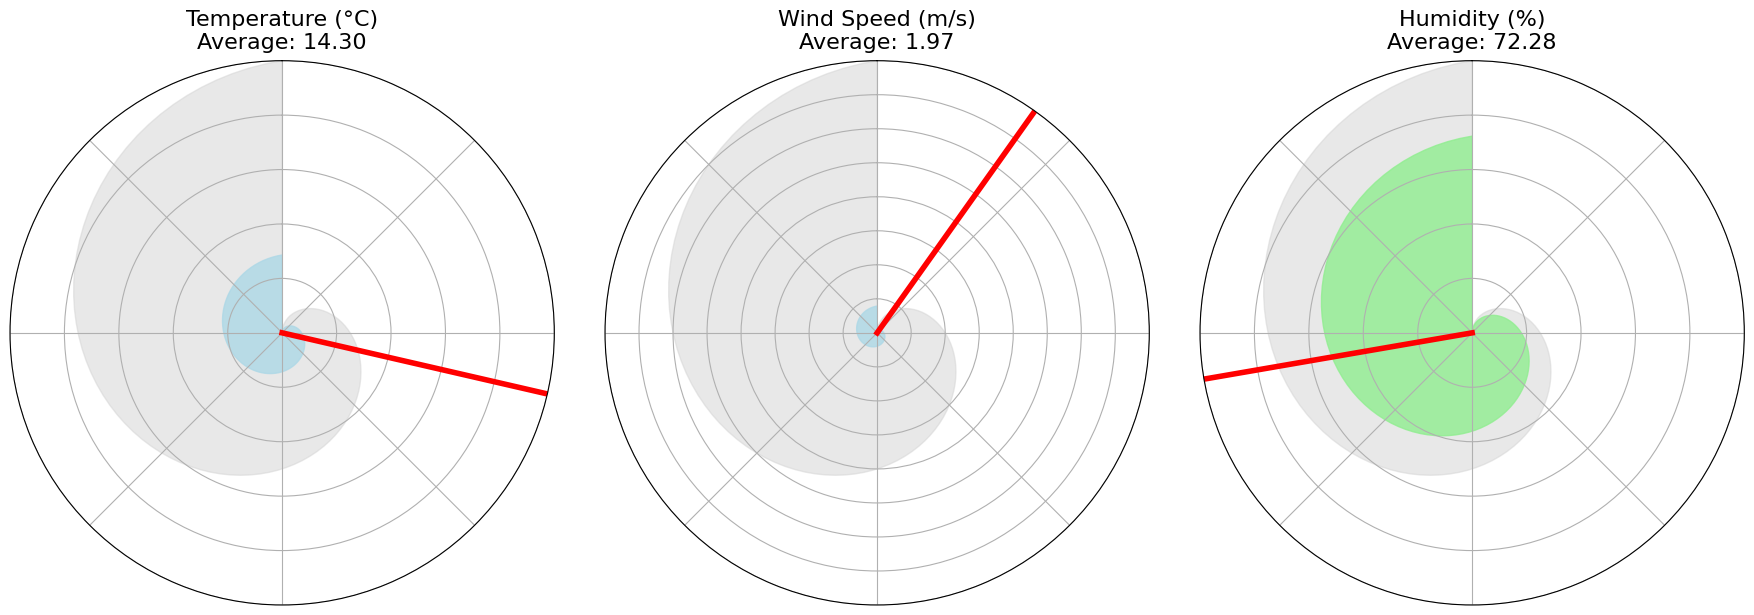

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a gauge chart
def create_gauge_chart(value, title, min_val, max_val, ax):
    # Set up the figure and axis
    ax.set_theta_offset(np.pi / 2)  # Rotate the chart so it starts from the bottom
    ax.set_theta_direction(-1)  # Reverse direction for more intuitive chart
    ax.set_ylim(0, max_val)  # Set the gauge scale between min_val and max_val

    # Create the filled arc for the gauge
    angles = np.linspace(0, 2 * np.pi, 100)
    ax.fill(angles, np.linspace(min_val, max_val, len(angles)), color="lightgray", alpha=0.5)

    # Color the section based on value
    color = "lightblue" if value < (max_val - min_val) / 2 else "lightgreen"
    ax.fill(angles, np.linspace(min_val, value, len(angles)), color=color, alpha=0.8)

    # Plot the value as the needle
    value_angle = (value - min_val) / (max_val - min_val) * 2 * np.pi
    ax.plot([value_angle, value_angle], [0, max_val], color="red", lw=4)

    # Add title
    ax.set_title(title, size=16, va='bottom')

    # Remove radial labels and ticks
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Create the figure and axes for 3 gauges (Temperature, Wind Speed, Humidity)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

# Gauge for Temperature
create_gauge_chart(average_temp, f"Temperature (°C)\nAverage: {average_temp:.2f}", 0, 50, axs[0])

# Gauge for Wind Speed
create_gauge_chart(average_wind_speed, f"Wind Speed (m/s)\nAverage: {average_wind_speed:.2f}", 0, 20, axs[1])

# Gauge for Humidity
create_gauge_chart(average_humidity, f"Humidity (%)\nAverage: {average_humidity:.2f}", 0, 100, axs[2])

# Show the plot
plt.tight_layout()
plt.show()


Displaying weather data for Srinagar


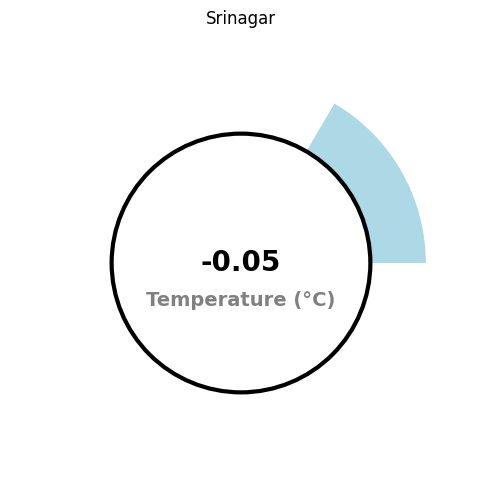

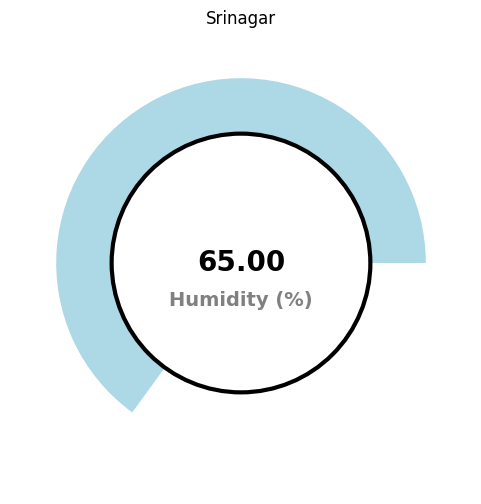

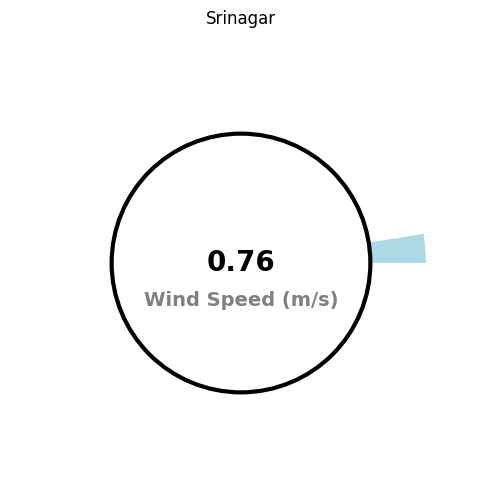

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create and display a gauge chart
def create_gauge_chart(value, title, min_val, max_val):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a circular gauge
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Define the color palette with a gradient-like effect
    colors = ["lightblue", "white"]
    
    # Compute the angle based on the value
    angle = (value - min_val) / (max_val - min_val) * 180

    # Create the gauge segments
    ax.pie([angle, 180 - angle], startangle=0, colors=colors, wedgeprops={'width': 0.3})
    
    # Add a border circle to give it a more polished look
    circle = plt.Circle((0, 0), 0.7, color='black', fill=False, linewidth=3)
    ax.add_artist(circle)

    # Add title and value text
    ax.text(0, 0, f"{value:.2f}", ha='center', va='center', fontweight="bold", fontsize=20, color="black")
    ax.text(0, -0.2, title, ha='center', va='center', fontweight="bold", fontsize=14, color='gray')
    
    # Remove axes
    ax.axis('off')
    plt.title(city_name)
    # Show the plot
    plt.show()

# Function to display the data for a specific city from pandas_df
def display_city_weather_data(city_name, pandas_df):
    # Check if the city exists in the DataFrame
    if city_name in pandas_df["City"].values:
        city_data = pandas_df.loc[pandas_df["City"] == city_name].iloc[0]
        
        # Fetch the weather data for the city
        city_temp = city_data["Temperature"]
        city_humidity = city_data["Humidity"]
        city_wind_speed = city_data["WindSpeed"]
        
        print(f"Displaying weather data for {city_name}")
        
        # Show temperature gauge
        create_gauge_chart(city_temp, f"Temperature (°C)", min_val=-10, max_val=50)

        # Show humidity gauge
        create_gauge_chart(city_humidity, f"Humidity (%)", min_val=0, max_val=100)

        # Show wind speed gauge
        create_gauge_chart(city_wind_speed, f"Wind Speed (m/s)", min_val=0, max_val=30)
    else:
        print(f"City '{city_name}' not found in the DataFrame.")

# Example usage with a specific city
city_name = "Srinagar"  # Replace with your city name
display_city_weather_data(city_name, pandas_df)


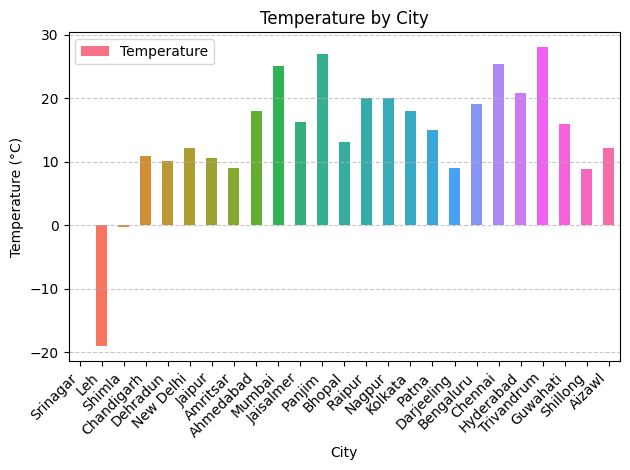

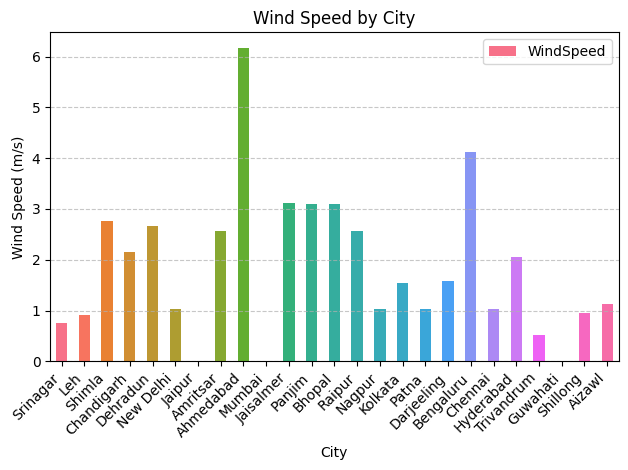

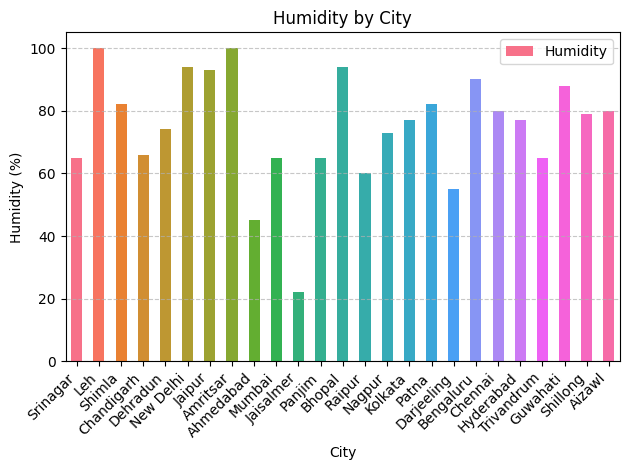

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a seaborn color palette for more vibrant visuals
palette = sns.color_palette("husl", len(pandas_df))

# Temperature bar chart
pandas_df.plot(
    kind="bar",
    x="City",
    y="Temperature",
    title="Temperature by City",
    color=palette
)
plt.ylabel("Temperature (°C)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Wind speed bar chart
pandas_df.plot(
    kind="bar",
    x="City",
    y="WindSpeed",
    title="Wind Speed by City",
    color=palette
)
plt.ylabel("Wind Speed (m/s)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Humidity bar chart
pandas_df.plot(
    kind="bar",
    x="City",
    y="Humidity",
    title="Humidity by City",
    color=palette
)
plt.ylabel("Humidity (%)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

/Users/rachit/dev/bdafinal/venv-3.11/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip

/Users/rachit/dev/bdafinal/venv-3.11/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip

/Users/rachit/dev/bdafinal/venv-3.11/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip



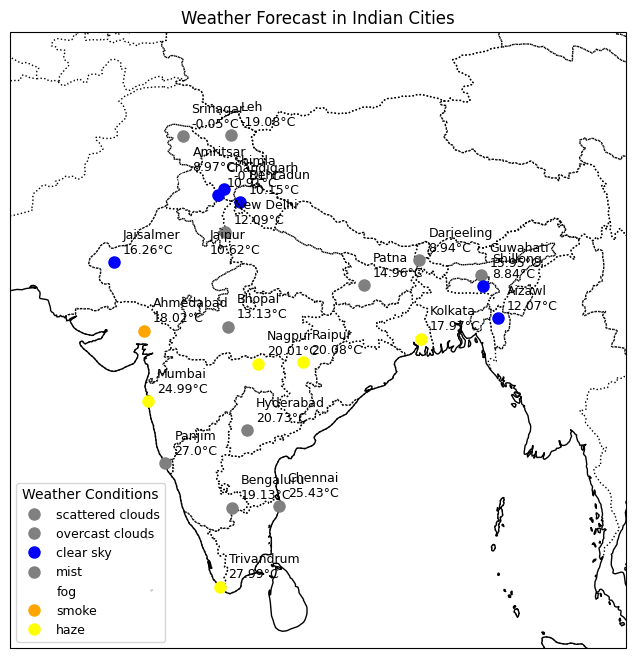

In [56]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define weather categories mapped to colors
weather_colors = {
    "overcast clouds": "gray",
    "light intensity drizzle": "lightblue",
    "broken clouds": "purple",
    "fog": "white",
    "few clouds": "skyblue",
    "smoke": "orange",
    "clear sky": "blue",
    "haze": "yellow"
}

# Create a figure with Cartopy's projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([65, 100, 5, 40], crs=ccrs.PlateCarree())  # Set bounds for India

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.STATES, linestyle=":")

# Plot the data points
for index, row in pandas_df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    city, weather, temp = row["City"], row["Weather"], row["Temperature"]
    ax.plot(lon, lat, 'o', color=weather_colors.get(weather, "gray"), markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + 0.5, lat + 0.5, f"{city}\n{temp}°C", fontsize=9, transform=ccrs.PlateCarree())

# Add a legend
unique_weathers = pandas_df["Weather"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=weather_colors.get(weather, "gray"),
                      markersize=10, label=weather) for weather in unique_weathers]
plt.legend(handles=handles, loc='lower left', title="Weather Conditions", fontsize=9)

# Show the plot
plt.title("Weather Forecast in Indian Cities")
plt.show()


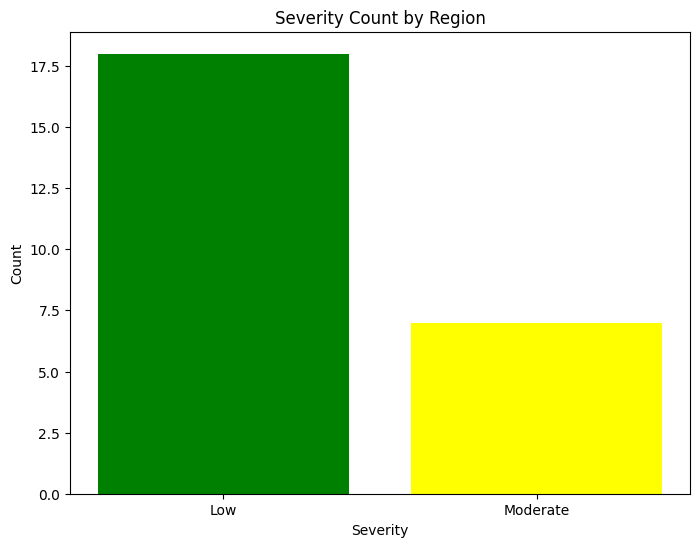

In [64]:
import matplotlib.pyplot as plt

# Assuming severity_count is a PySpark DataFrame, convert it to pandas
severity_pandas_df = severity_count.toPandas()

# Define a color mapping for severity levels
color_mapping = {
    "Low": "green",
    "Moderate": "yellow",
    "High": "orange",
    "Severe": "red"
}

# Map colors to the severity levels in the DataFrame
severity_pandas_df["Color"] = severity_pandas_df["Severity"].map(color_mapping)

# Create a bar chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(
    severity_pandas_df["Severity"], 
    severity_pandas_df["count"], 
    color=severity_pandas_df["Color"]
)

# Add title and labels
plt.title("Severity Count by Region")
plt.xlabel("Severity")
plt.ylabel("Count")

# Show the plot
plt.show()

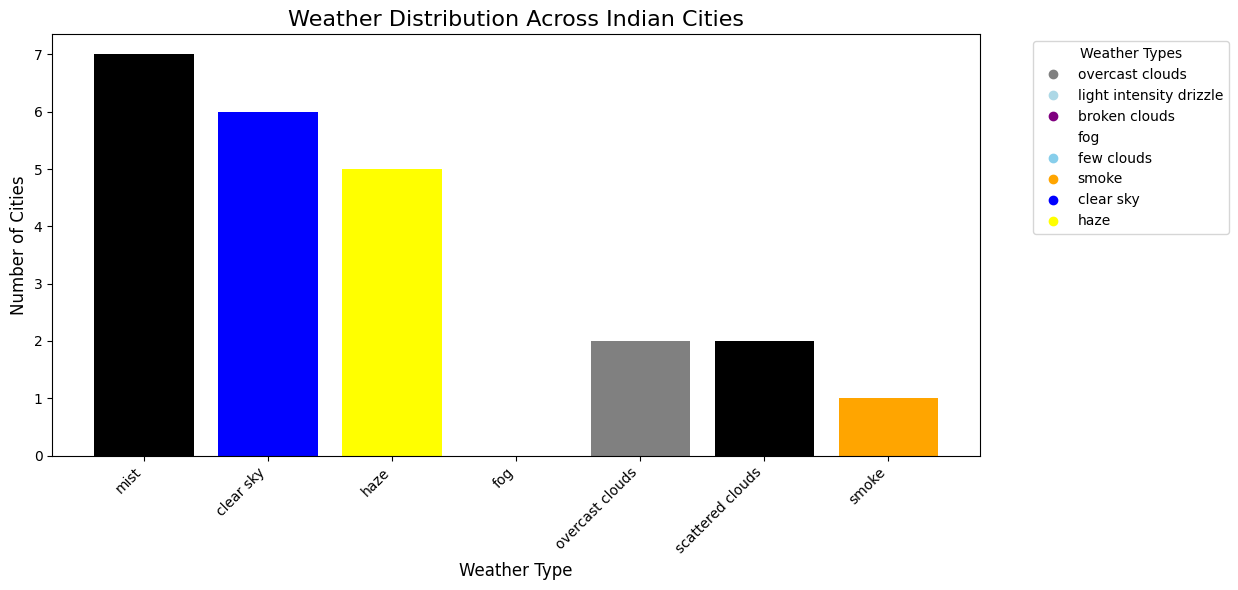

In [58]:
import matplotlib.pyplot as plt

# Group by 'Weather' to count the number of cities for each weather type
weather_counts = pandas_df.groupby("Weather").size()

# Define a color mapping for weather types
weather_colors = {
    "overcast clouds": "gray",
    "light intensity drizzle": "lightblue",
    "broken clouds": "purple",
    "fog": "white",
    "few clouds": "skyblue",
    "smoke": "orange",
    "clear sky": "blue",
    "haze": "yellow",
}

# Prepare data for the bar chart
weather_counts_sorted = weather_counts.sort_values(ascending=False)
weather_types = weather_counts_sorted.index
counts = weather_counts_sorted.values
colors = [weather_colors.get(weather, "black") for weather in weather_types]  # Default to 'black' if no color is defined

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(weather_types, counts, color=colors)

# Add labels and title
plt.title("Weather Distribution Across Indian Cities", fontsize=16)
plt.xlabel("Weather Type", fontsize=12)
plt.ylabel("Number of Cities", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Add a legend for weather colors
handles = [plt.Line2D([0], [0], marker='o', color=color, label=weather, linestyle='') for weather, color in weather_colors.items()]
plt.legend(handles=handles, title="Weather Types", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()


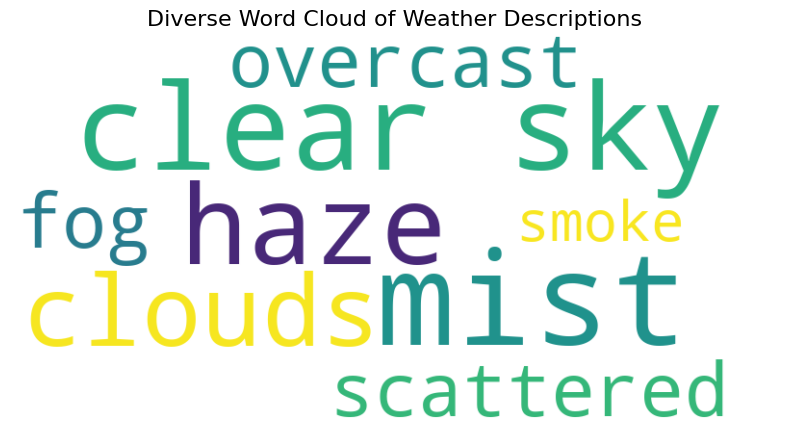

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all weather descriptions into a single string
weather_descriptions = pandas_df["Weather"].tolist()

# Count occurrences of each weather description
weather_counts = Counter(weather_descriptions)

# Expand the descriptions proportional to their frequency
weighted_weather_text = " ".join(
    [desc for desc, count in weather_counts.items() for _ in range(count)]
)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    max_words=100  # Limit to the top 100 most frequent words for better diversity
).generate(weighted_weather_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Diverse Word Cloud of Weather Descriptions", fontsize=16)
plt.show()

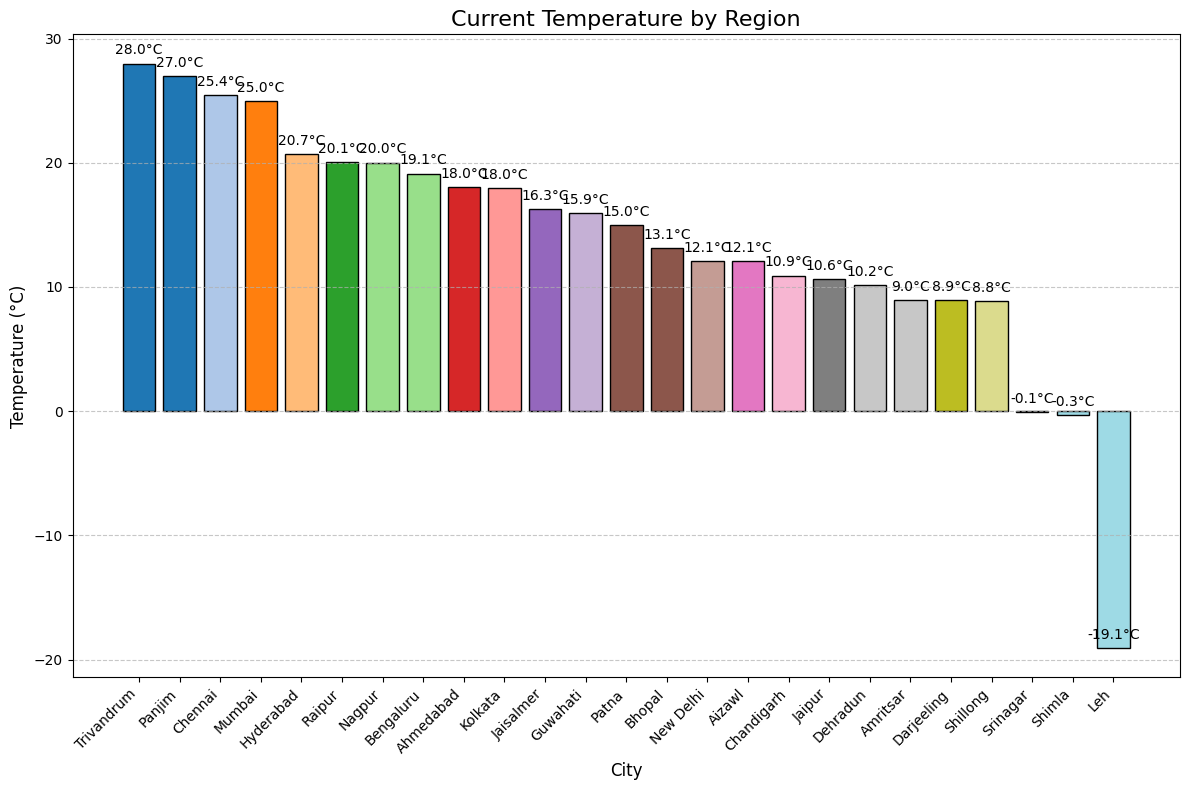

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by temperature for better visualization
pandas_df_sorted = pandas_df.sort_values(by="Temperature", ascending=False)

# Generate unique colors for each bar
num_cities = len(pandas_df_sorted)
colors = plt.cm.tab20(np.linspace(0, 1, num_cities))  # Use a colormap for diverse colors

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(
    pandas_df_sorted["City"],
    pandas_df_sorted["Temperature"],
    color=colors,
    edgecolor="black"
)

# Add labels and title
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xlabel("City", fontsize=12)
plt.title("Current Temperature by Region", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate each bar with the temperature value
for bar, temp in zip(bars, pandas_df_sorted["Temperature"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{temp:.1f}°C",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"
    )

# Show the chart
plt.tight_layout()
plt.show()

Cluster 0:
Cities: Mumbai, Nagpur, Kolkata, Patna, Chennai, Hyderabad, Trivandrum, Guwahati
Weather Descriptions: haze, haze, haze, mist, mist, mist, haze, mist

Cluster 1:
Cities: Shimla, Dehradun, Amritsar, Bhopal, Bengaluru
Weather Descriptions: clear sky, clear sky, fog, mist, mist

Cluster 2:
Cities: Srinagar, Leh, New Delhi, Jaipur, Shillong, Aizawl
Weather Descriptions: scattered clouds, overcast clouds, mist, fog, clear sky, clear sky

Cluster 3:
Cities: Chandigarh, Ahmedabad, Jaisalmer, Panjim, Raipur, Darjeeling
Weather Descriptions: clear sky, smoke, clear sky, scattered clouds, haze, overcast clouds



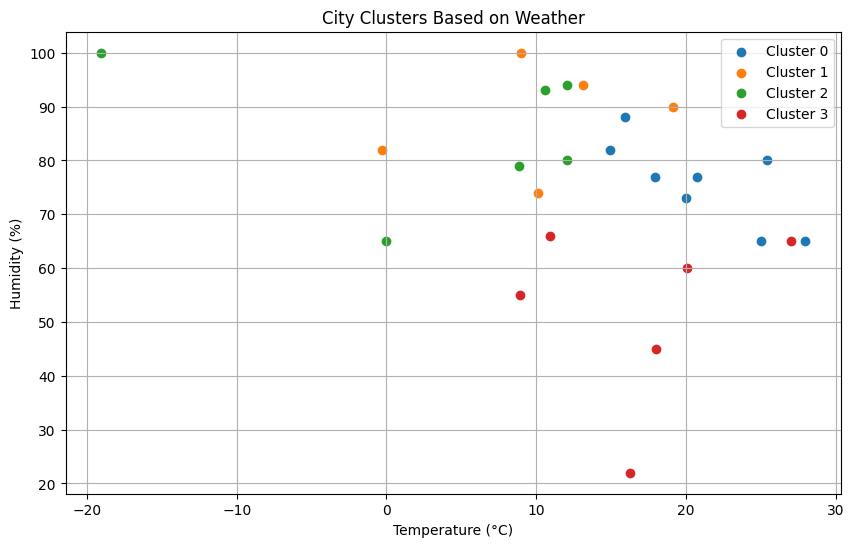

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Select relevant features for clustering
features = pandas_df[["Temperature", "Humidity", "WindSpeed"]]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
pandas_df["Cluster"] = kmeans.fit_predict(scaled_features)

# Group the cities by clusters
clustered_cities = pandas_df.groupby("Cluster")[["City", "Weather"]].agg(list).reset_index()

# Display the clusters
for index, row in clustered_cities.iterrows():
    print(f"Cluster {row['Cluster']}:")
    print(f"Cities: {', '.join(row['City'])}")
    print(f"Weather Descriptions: {', '.join(row['Weather'])}\n")

# Optional: Visualize clusters in 2D space (e.g., using PCA for dimensionality reduction)
plt.figure(figsize=(10, 6))
for cluster in range(4):
    cluster_data = pandas_df[pandas_df["Cluster"] == cluster]
    plt.scatter(
        cluster_data["Temperature"],
        cluster_data["Humidity"],
        label=f"Cluster {cluster}"
    )

plt.title("City Clusters Based on Weather")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.legend()
plt.grid()
plt.show()

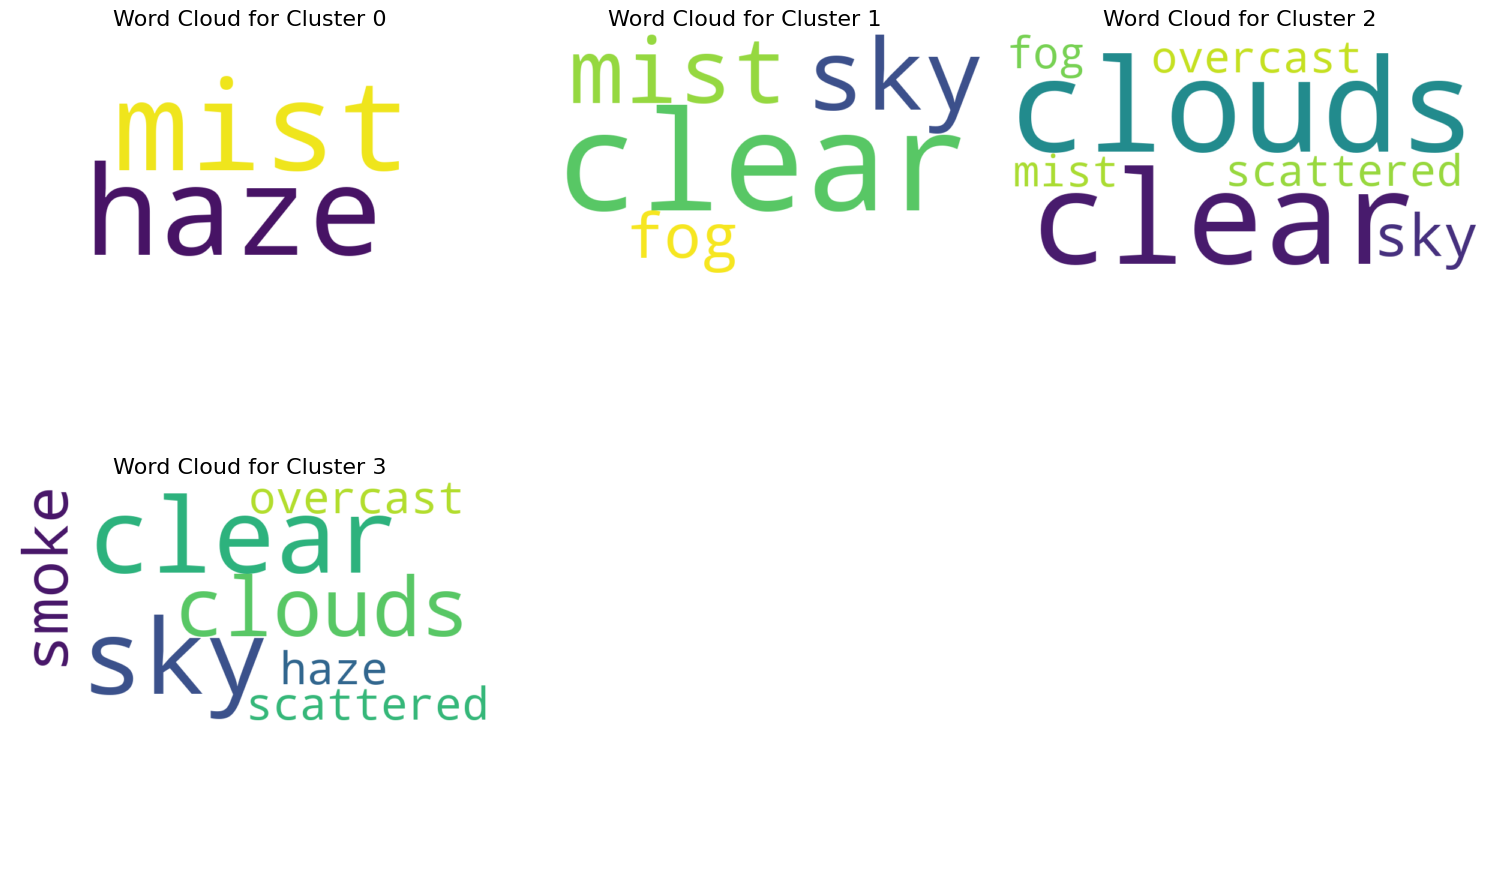

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary for weather descriptions grouped by cluster
cluster_weather = (
    pandas_df.groupby("Cluster")["Weather"]
    .apply(lambda descriptions: " ".join(descriptions))
    .to_dict()
)

# Determine the number of clusters
num_clusters = len(cluster_weather)

# Set up a subplot grid (adjust the grid size as needed)
rows = (num_clusters // 3) + (num_clusters % 3 > 0)  # Dynamically determine rows
cols = min(3, num_clusters)  # Limit columns to 3

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Flatten axes array in case of multi-row/multi-column subplot layout
axes = axes.flatten()

# Generate and display a word cloud for each cluster
for idx, (cluster, weather_text) in enumerate(cluster_weather.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis"
    ).generate(weather_text)

    # Display the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].axis("off")  # Hide axes
    axes[idx].set_title(f"Word Cloud for Cluster {cluster}", fontsize=16)

# Hide any unused subplots (if the grid size is larger than the number of clusters)
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()